# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

In [20]:
path = "../data/png"

In [3]:
np.random.seed(42)
ids = np.arange(101,126)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,5))
ids

array([[109, 117, 101, 124, 112],
       [110, 114, 102, 123, 106],
       [103, 113, 116, 104, 105],
       [121, 118, 122, 119, 125],
       [108, 111, 115, 120, 107]])

In [4]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        #print("init")
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def encodes(self, o:PILMask):
        #print("encodes")
        mo = ToTensor()(o)
        mo = mo.to(dtype=torch.long)
        mo = self.mapping.index_select(0,mo.flatten()).reshape(*mo.shape)
        mo = PILMask.create(mo.to(dtype=torch.uint8))
        return mo
    
    def decodes(self, o:TensorMask):
        # decoding of inputs works out of the box, but get_preds are not properly decoded
        if len(o.shape) > 2:
            o = o.argmax(dim=0)
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

In [5]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [6]:
def getMappedMaskBlock(predefined_mapping_name):
    predefined_mappings = {
        'full': ([0,1,2,3,4,5],['bg','lv','my','rv','ed','sc']),
        'edOnly': ([0,0,0,0,1,0],['bg','ed']),
        'edScCombined': ([0,0,0,0,1,1],['bg','edSc']),
        'scOnly': ([0,0,0,0,0,1],['bg','sc']),
        'edScOnly': ([0,0,0,0,1,2],['bg','ed','sc']),
    }
    mapping,codes = predefined_mappings[predefined_mapping_name]
    return MappedMaskBlock(mapping = torch.LongTensor(mapping), codes=codes)

In [8]:
def getMyopsDls(val_ids, mapping_name="full", images="images"):
    mmb = getMappedMaskBlock(mapping_name)
    myopsData = DataBlock(blocks=(ImageBlock, mmb),#['bg','lv','my','rv','ed','sc'])),
        get_items=get_image_files,
        splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in val_ids),
        get_y=lambda o: str(o).replace(images,"masks"),
        item_tfms=CropPad(256),
        batch_tfms=aug_transforms(max_rotate=90,pad_mode="zeros"))
    return myopsData.dataloaders(f'{path}/{images}',num_workers=8,batch_size=12)

In [16]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceFG(input, targs): return multi_dice(input,targs,class_id=1)
def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [10]:
def myFocal(weights=[.2,.8]):
    monaiFocal = FocalLoss(weight=torch.Tensor(weights),reduction='mean')
    return lambda input,target: monaiFocal(input, target.unsqueeze(1))

# Generic function

In [22]:
def standard_training(mapping="full",images="images",cleanup=True,metrics=dices,weights=[1.0/6,1.0/6,1.0/6,1.0/6,1.0/6,1.0/6],cv=0,name="standard_training",use_focal_loss=True):
    my_loss = CrossEntropyLossFlat()
    if(use_focal_loss):
        my_loss = myFocal(weights)
    learn = unet_learner(getMyopsDls(ids[cv], mapping, images), resnet34, loss_func=my_loss, metrics=[foreground_acc, *metrics],callbacks=[CSVLogger(name,append=True)])
    learn.fine_tune(20, freeze_epochs=10, base_lr=1e-3)
    learn.export(name)
    if not cleanup:
        return learn
    else:
        del learn
        gc.collect()
        torch.cuda.empty_cache()

In [25]:
mapping="full"
images="images"
cleanup=True
metrics=dices
weights=[1.0/6,1.0/6,1.0/6,1.0/6,1.0/6,1.0/6]
cv=0
name="standard_training"
use_focal_loss=True

RuntimeError: normal_ expects std > 0.0, but found std=0

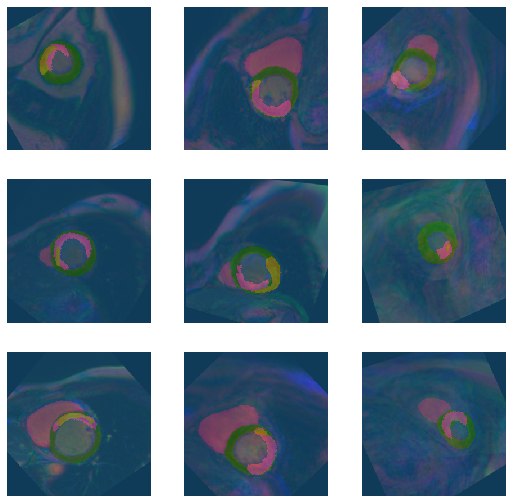

In [37]:
my_loss = myFocal([.1,.1,.1,.1,.3,.3])
dls = getMyopsDls(ids[cv], mapping, images)
dls.show_batch()
learn = unet_learner(getMyopsDls(ids[cv], mapping, images), resnet34)#, loss_func=my_loss)#, metrics=[foreground_acc, *metrics])#,callbacks=[CSVLogger(name,append=True)])

In [23]:
standard_training(name="balanced_0")

RuntimeError: normal_ expects std > 0.0, but found std=0

# Edema only - multimodal

epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.014482,0.007171,0.000000,0.155280,00:33
1,0.008577,0.005031,0.125028,0.107884,00:33
2,0.006214,0.003727,0.387434,0.214310,00:33
3,0.005254,0.003547,0.206826,0.217478,00:33
4,0.004842,0.003469,0.044619,0.178027,00:33


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.004060,0.003264,0.539856,0.245733,00:34
1,0.003990,0.003725,0.263718,0.235254,00:34
2,0.003645,0.003869,0.258279,0.261421,00:34
3,0.003383,0.003266,0.347528,0.283154,00:34
4,0.003141,0.003276,0.388741,0.280900,00:34


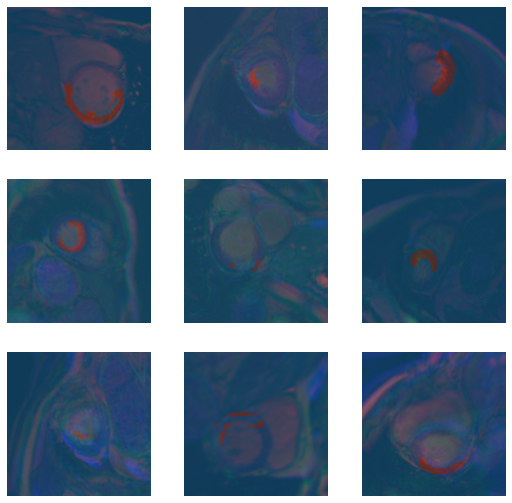

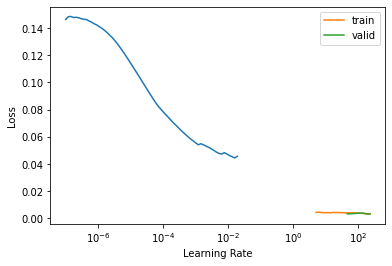

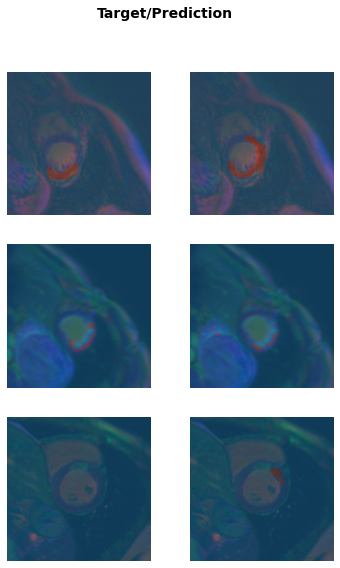

In [25]:
short_training("edOnly", "images")

# Combine edema and scar - T2

epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.015564,0.009133,0.082796,0.103798,00:32
1,0.010828,0.008423,0.191880,0.192927,00:32
2,0.009020,0.007392,0.505341,0.328935,00:32
3,0.008264,0.008332,0.302494,0.287137,00:32
4,0.007402,0.008237,0.281235,0.276297,00:32


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.006234,0.008371,0.497533,0.370925,00:33
1,0.006096,0.006043,0.481061,0.413126,00:33
2,0.005694,0.007257,0.470823,0.403319,00:33
3,0.005267,0.008209,0.363484,0.387844,00:33
4,0.004958,0.007093,0.458848,0.406367,00:33


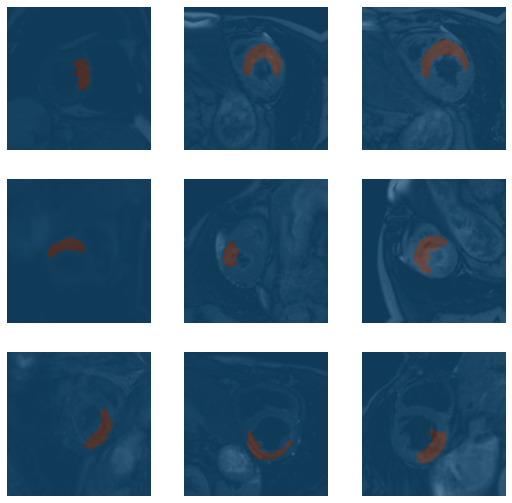

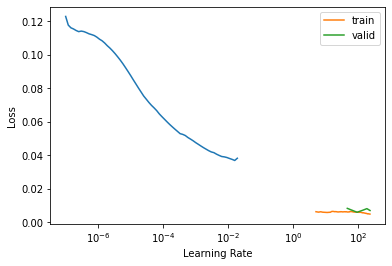

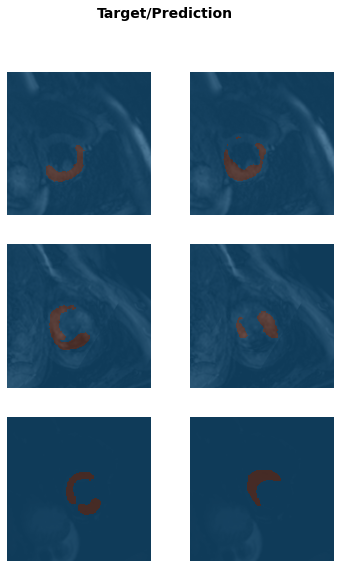

In [21]:
short_training("edScCombined", "T2")

# Combine edema and scar - multimodal

epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.018990,0.009553,0.263127,0.200725,01:33
1,0.012020,0.006950,0.692961,0.400280,00:33
2,0.008874,0.006046,0.650027,0.442417,00:33
3,0.007482,0.006968,0.781966,0.392910,00:33
4,0.006344,0.005503,0.715211,0.475626,00:33


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.004724,0.004979,0.619403,0.507142,00:34
1,0.005250,0.006373,0.658304,0.483091,00:34
2,0.004967,0.004828,0.657856,0.518101,00:34
3,0.004443,0.004944,0.670174,0.544922,00:34
4,0.004011,0.004965,0.679380,0.554360,00:34


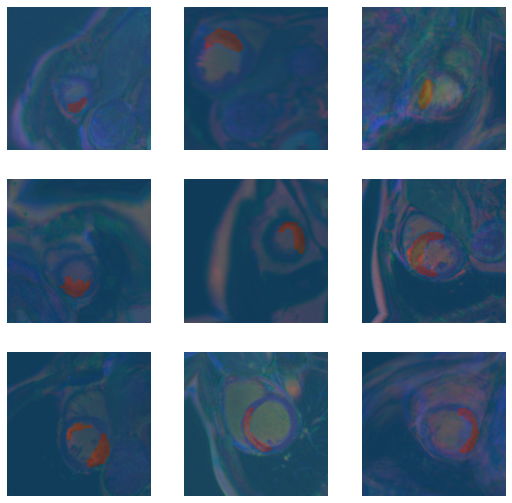

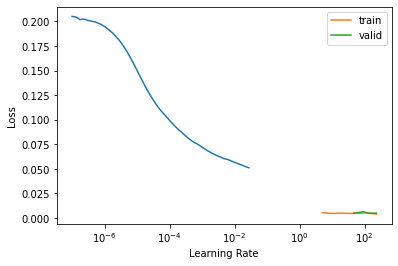

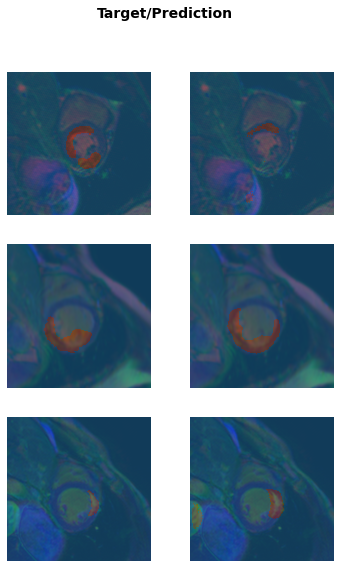

In [22]:
short_training("edScCombined", "images")

# Scar only - LGE

epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.008706,0.006883,0.276308,0.250126,01:30
1,0.007058,0.005240,0.238975,0.258379,00:32
2,0.006477,0.005392,0.159708,0.201456,00:32
3,0.005887,0.004885,0.146415,0.236034,00:31
4,0.005186,0.006161,0.278169,0.310740,00:32


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.003722,0.004539,0.674076,0.353959,00:33
1,0.004022,0.004146,0.583311,0.384161,00:33
2,0.003557,0.005277,0.427451,0.370307,00:33
3,0.003343,0.003971,0.612283,0.400156,00:33
4,0.002964,0.004660,0.425242,0.380593,00:33


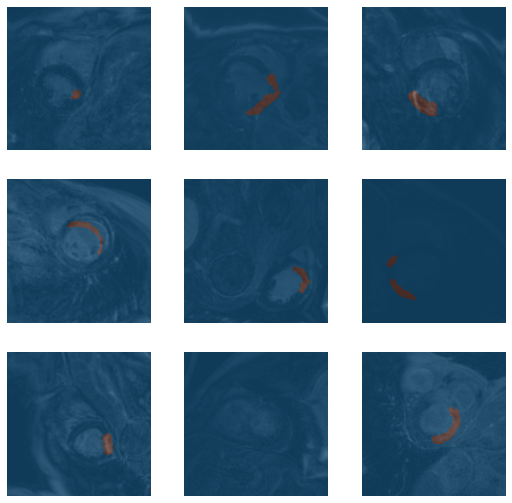

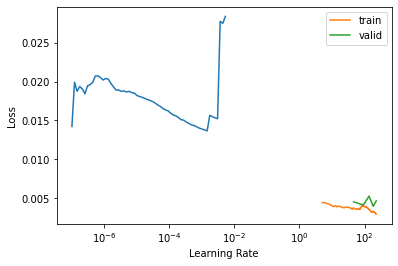

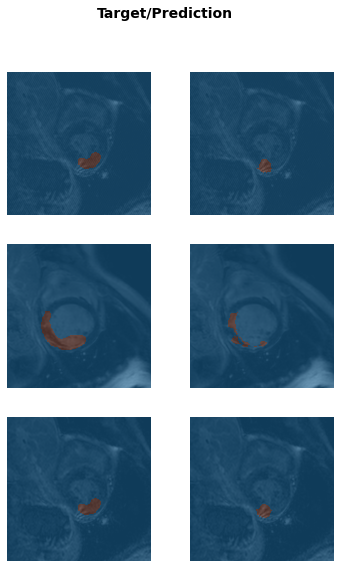

In [23]:
short_training("scOnly", "LGE")

# Scar only - multimodal

epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.012683,0.007551,0.048813,0.107803,00:33
1,0.008461,0.006107,0.207660,0.224122,00:33
2,0.006377,0.005248,0.444519,0.360057,00:33
3,0.005543,0.004125,0.608650,0.346870,00:33
4,0.005067,0.003930,0.576595,0.398379,00:33


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.003427,0.003971,0.486660,0.413849,00:34
1,0.003555,0.004295,0.575948,0.377811,00:34
2,0.003100,0.003890,0.584439,0.438977,00:34
3,0.002834,0.003880,0.553723,0.450335,00:34
4,0.002649,0.003864,0.576140,0.444891,00:34


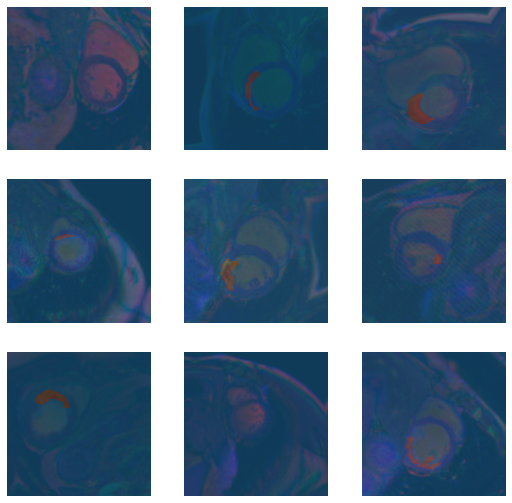

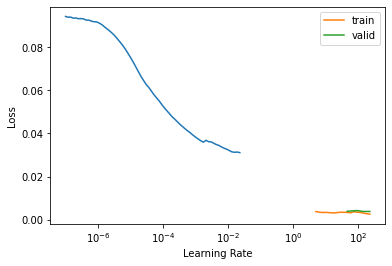

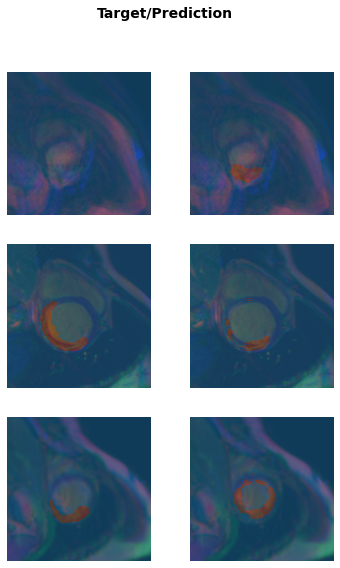

In [24]:
short_training("scOnly", "images")

# Pathology only - multimodal

epoch,train_loss,valid_loss,foreground_acc,diceEd,diceSc,time
0,0.034511,0.016195,0.001664,0.173913,0.128157,00:41
1,0.019055,0.010687,0.101792,0.157143,0.163557,00:34
2,0.013479,0.010086,0.223499,0.194031,0.281151,00:33
3,0.010907,0.007332,0.282999,0.176303,0.437766,00:33
4,0.011172,0.007901,0.108239,0.172106,0.212937,00:33


epoch,train_loss,valid_loss,foreground_acc,diceEd,diceSc,time
0,0.008841,0.007576,0.252475,0.203452,0.380290,00:35
1,0.008305,0.007343,0.306082,0.245428,0.400047,00:35
2,0.007729,0.008809,0.299813,0.256919,0.418296,00:34
3,0.006989,0.006854,0.436159,0.242357,0.440544,00:34
4,0.006422,0.006856,0.404519,0.225925,0.426142,00:34


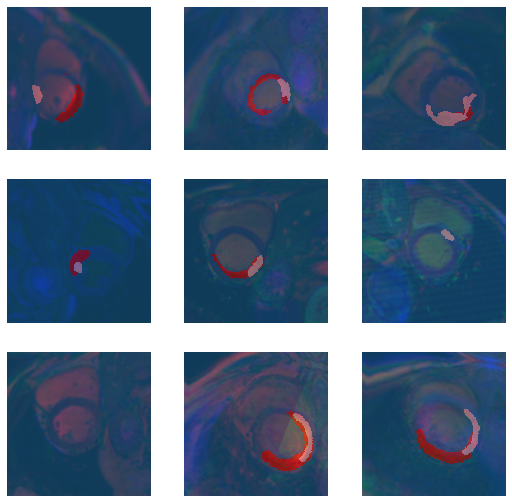

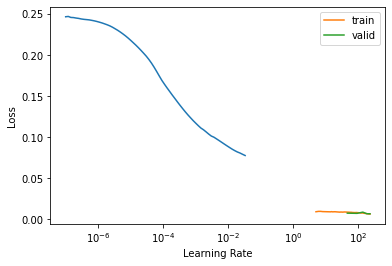

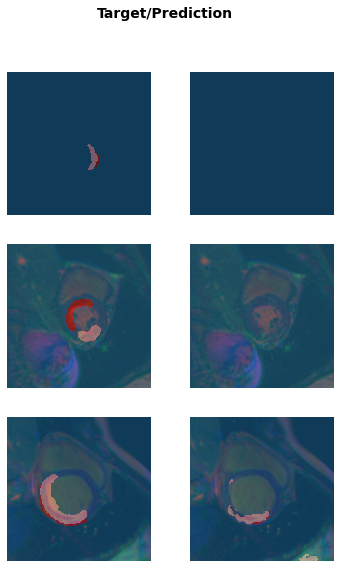

In [15]:
def diceEd(input, targs): return multi_dice(input,targs,class_id=1)
def diceSc(input, targs): return multi_dice(input,targs,class_id=2)
short_training("edScOnly", "images", metrics=[diceEd,diceSc], weights=[.2,.4,.4])